# Quantize a Segmentation Model and Show Live Inference

## Kidney Segmentation with PyTorch Lightning and OpenVINO™ - Part 3

This tutorial is part of a series on how to train, optimize, quantize and show live inference on a medical segmentation model. The goal is to accelerate inference on a kidney segmentation model. The [UNet](https://arxiv.org/abs/1505.04597) model is trained from scratch; the data is from [Kits19](https://github.com/neheller/kits19).

This third tutorial in the series shows how to:

- Convert an ONNX model to OpenVINO IR with [Model Optimizer](https://docs.openvinotoolkit.org/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html),
- Quantize a model with OpenVINO's [Post-Training Optimization Tool](https://docs.openvinotoolkit.org/latest/pot_compression_api_README.html) API. 
- Evaluate the F1 score metric of the original model and the quantized model
- Benchmark performance of the original model and the quantized model
- Show live inference with OpenVINO's async API and MULTI plugin

All notebooks in this series:

- [Data Preparation for 2D Segmentation of 3D Medical Data](data-preparation-ct-scan.ipynb)
- [Train a 2D-UNet Medical Imaging Model with PyTorch Lightning](pytorch-monai-training.ipynb)
- Convert and Quantize a Segmentation Model and Show Live Inference (this notebook)
- [Live Inference and Benchmark CT-scan data](../210-ct-scan-live-inference/210-ct-scan-live-inference.ipynb) 

## Instructions

This notebook needs a trained UNet model that is converted to [ONNX](https://github.com/onnx/onnx) format. We provide a pretrained model trained for 20 epochs with the full [Kits-19](https://github.com/neheller/kits19) frames dataset, which has an F1 score on the validation set of 0.9. The training code is available in [this notebook](pytorch-monai-training.ipynb). 

Running this notebook with the full dataset will take a long time. For demonstration purposes, this tutorial will download one converted CT scan and use that scan for quantization and inference. For production use, please use a larger dataset for more generalizable results.

## Imports

The Post Training Optimization API is implemented in the `compression` library.

In [1]:
import os
import random
import sys
import time
import warnings
import zipfile
from pathlib import Path

warnings.filterwarnings("ignore")
import cv2
import matplotlib.pyplot as plt
import numpy as np
from addict import Dict
from compression.api import DataLoader, Metric
from compression.engines.ie_engine import IEEngine
from compression.graph import load_model, save_model
from compression.graph.model_utils import compress_model_weights
from compression.pipeline.initializer import create_pipeline
from openvino.inference_engine import IECore
from yaspin import yaspin

sys.path.append("../utils")
from models.custom_segmentation import SegmentationModel
from notebook_utils import benchmark_model, download_file, show_live_inference

16:54:55 accuracy_checker WARNING: /home/helena/code/openvino_notebooks/openvino_env/lib/python3.8/site-packages/defusedxml/__init__.py:30: DeprecationWarning: defusedxml.cElementTree is deprecated, import from defusedxml.ElementTree instead.
  from . import cElementTree



## Settings

To use the pretrained models, set `ONNX_PATH` to `"pretrained_model/unet_kits19.onnx"`. To use a model that you trained or optimized yourself, adjust `ONNX_PATH`. Running the next cell will check if a model trained in the [training notebook](pytorch-monai-training.ipynb) is saved in MODEL_DIR and if so, use that. If there is no trained model, the pretrained model will be used. The optimized OpenVINO Intermediate Representation (IR) model will be saved in `MODEL_DIR`. 

By default, this notebook will download one CT scan from the KITS19 dataset, and use that for quantization. To use the full dataset, set `BASEDIR` to the path of the dataset, as prepared according to the [Data Preparation](data-preparation-ct-scan.ipynb) notebook.

In [4]:
BASEDIR = Path("/home/helena/code/kidney_segmentation/kits19_frames")
# Uncomment the line below to use the full dataset, as prepared in the data preparation notebook
# BASEDIR = Path("~/kits19/kits19_frames").expanduser()
MODEL_DIR = Path("model")
ONNX_PATH = MODEL_DIR / "unet_kits19.onnx"
if not ONNX_PATH.exists():
    ONNX_PATH = Path("pretrained_model/pretrained_unet_kits19.onnx")
assert ONNX_PATH.exists(), f"ONNX_PATH: {ONNX_PATH} does not exist"

ir_path = (MODEL_DIR / ONNX_PATH.stem).with_suffix(".xml")

print(f"ONNX model: {ONNX_PATH}")
print(f"Optimized model will be saved to: {ir_path}")

ONNX model: pretrained_model/pretrained_unet_kits19.onnx
Optimized model will be saved to: model/pretrained_unet_kits19.xml


## Download CT-scan Data

In [5]:
# The CT scan case number. For example: 2 for data from the case_00002 directory
# Currently only 117 is supported
CASE = 117
if not (BASEDIR / f"case_{CASE:05d}").exists():
    BASEDIR.mkdir(exist_ok=True)
    filename = download_file(
        f"https://storage.openvinotoolkit.org/data/test_data/openvino_notebooks/kits19/case_{CASE:05d}.zip"
    )
    with zipfile.ZipFile(filename, "r") as zip_ref:
        zip_ref.extractall(path=BASEDIR)
    os.remove(filename)  # remove zipfile
    print(f"Downloaded and extracted data for case_{CASE:05d}")
else:
    print(f"Data for case_{CASE:05d} exists")

Data for case_00117 exists


## Convert Model to OpenVINO IR
Call the Model Optimizer tool to convert the ONNX model to OpenVINO IR, with FP16 precision. The model files are saved to the MODEL_DIR directory. See the [Model Optimizer Developer Guide](https://docs.openvinotoolkit.org/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) for more information.

Model Optimization was successful if the last lines of the output include `[ SUCCESS ] Generated IR version 10 model`.

In [7]:
MODEL_DIR.mkdir(exist_ok=True)
!mo --input_model $ONNX_PATH --output_dir $MODEL_DIR --data_type FP16

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/helena/code/openvino_notebooks/notebooks/110-ct-segmentation-quantize/pretrained_model/pretrained_unet_kits19.onnx
	- Path for generated IR: 	/home/helena/code/openvino_notebooks/notebooks/110-ct-segmentation-quantize/model
	- IR output name: 	pretrained_unet_kits19
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
ONNX specific parameters:
	- Inference Engine found in: 	/home/helena/code/openvino_notebooks/openvino_env/lib/python3.8/site-packag

## Post-Training Optimization Tool (POT) Quantization
The Post-Training Optimization Tool (POT) `compression` API defines base classes for `Metric` and `DataLoader`. In this notebook, we use a custom Metric and DataLoader that show all the required methods.

### Configuration

#### Metric
Define a metric to determine the performance of the model. For the Default Quantization algorithm that is used in this tutorial, defining a metric is optional. The metric is used to compare the quantized INT8 model with the original FP16 IR model.

A metric for POT inherits from `compression.api.Metric` and should implement all the methods in this example.

For this demo, the [F1 score](https://en.wikipedia.org/wiki/F-score), or Dice coefficient, is used. The same metric implementation is used in the [training notebook](pytorch-monai-training.ipynb).

In [8]:
# The sigmoid function is used to transform the result of the network
# to binary segmentation masks
def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))


class BinaryF1(Metric):
    """
    Metric to compute F1/Dice score for binary segmentation. F1 is computed as
    (2 * precision * recall) / (precision + recall) where precision is computed as
    the ratio of pixels that were correctly predicted as true and all actual true pixels,
    and recall as the ratio of pixels that were correctly predicted as true and all
    predicted true pixels.

    See https://en.wikipedia.org/wiki/F-score
    """

    # Required methods
    def __init__(self):
        super().__init__()
        self._name = "F1"
        self.y_true = 0
        self.y_pred = 0
        self.correct_true = 0

    @property
    def value(self):
        """
        Returns metric value for the last model output.
        Possible format: {metric_name: [metric_values_per_image]}
        """
        return {self._name: [0, 0]}

    @property
    def avg_value(self):
        """
        Returns average metric value for all model outputs as {metric_name: metric_value}
        """
        recall = self.correct_true / self.y_pred
        precision = self.correct_true / self.y_true

        f1 = (2 * precision * recall) / (precision + recall)
        return {self._name: f1}

    def update(self, output, target):
        """
        Update the statistics for metric computation

        :param output: model output
        :param target: annotations for model output
        """
        label = target[0].astype(np.byte)
        prediction = sigmoid(output[0]).round().astype(np.byte)

        self.y_true += np.sum(label)
        self.y_pred += np.sum(prediction)

        correct_true = np.sum(
            (label == prediction).astype(np.byte) * (label == 1).astype(np.byte)
        ).astype(np.float32)

        self.correct_true += correct_true

    def reset(self):
        """
        Resets metric to initial values
        """
        self.y_true = 0
        self.y_pred = 0
        self.correct_true = 0

    def get_attributes(self):
        """
        Returns a dictionary of metric attributes {metric_name: {attribute_name: value}}.
        Required attributes: 'direction': 'higher-better' or 'higher-worse'
                             'type': metric type
        """
        return {self._name: {"direction": "higher-better", "type": "F1"}}

#### Dataset

The dataset in the next cell expects images and masks in the *basedir* directory, in a folder per patient. For more information about the data in the dataset, see the [data preparation notebook](data-preparation-cit-scan.ipynb). This dataset follows POT's `compression.api.DataLoader` interface, which should implement `__init__`, `__getitem__` and `__len__`, where `__getitem__(index)` returns `(annotion, image)` or `(annotation, image, metadata)` and `annotation` consists of `(index, label)`.

In [9]:
class KitsDataset(DataLoader):
    def __init__(self, basedir: str, dataset_type: str):
        """
        Dataset class for prepared Kits19 data, for binary segmentation (background/kidney)
        Source data should exist in basedir, in subdirectories case_00000 until case_00210,
        with each subdirectory containing directories imaging_frames, with jpg images, and
        segmentation_frames with segmentation masks as png files.
        See https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/110-ct-segmentation-quantize/data-preparation-ct-scan.ipynb

        :param basedir: Directory that contains the prepared CT scans
        :param dataset_type: either "train" or "val"
        """
        allmasks = sorted(BASEDIR.glob("case_*/segmentation_frames/*png"))

        if len(allmasks) == 0:
            raise ValueError(
                f"basedir: '{basedir}' does not contain data for type '{dataset_type}'"
            )
        val_indices = [7, 10, 14, 15, 30, 60, 71, 74, 75, 81, 92, 93,
                       106, 115, 117, 119, 134, 161, 192, 196, 203]  # fmt: skip
        test_indices = [2, 5, 37, 103, 174]
        train_indices = set(list(range(210))) - set(val_indices) - set(test_indices)

        val_cases = [f"case_{i:05d}" for i in val_indices]
        test_cases = [f"case_{i:05d}" for i in test_indices]
        train_cases = [f"case_{i:05d}" for i in train_indices]

        if dataset_type == "train":
            masks = [mask for mask in allmasks if mask.parents[1].name in train_cases]
        elif dataset_type == "val":
            masks = [mask for mask in allmasks if mask.parents[1].name in val_cases]
        elif dataset_type == "test":
            masks = [mask for mask in allmasks if mask.parents[1].name in test_cases]
        else:
            raise ValueError("Please choose train, val or test dataset split")

        self.basedir = basedir
        self.dataset_type = dataset_type
        self.dataset = masks
        print(
            f"Created {dataset_type} dataset with {len(self.dataset)} items. "
            f"Base directory for data: {basedir}"
        )

    def __getitem__(self, index):
        """
        Get an item from the dataset at the specified index.

        :return: (annotation, input_image, metadata) where annotation is (index, segmentation_mask)
                 and metadata a dictionary with case and slice number
        """
        mask_path = self.dataset[index]
        # Open the image with OpenCV with `cv2.IMREAD_UNCHANGED` to prevent automatic
        # conversion of 1-channel black and white images to 3-channel BGR images.
        mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)

        image_path = str(mask_path.with_suffix(".jpg")).replace(
            "segmentation_frames", "imaging_frames"
        )
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

        if img.shape[:2] != (512, 512):
            img = cv2.resize(img, (512, 512))
            mask = cv2.resize(mask, (512, 512))

        annotation = (index, mask.astype(np.uint8))
        input_image = np.expand_dims(img, axis=0).astype(np.float32)
        return (
            annotation,
            input_image,
            {"case": Path(mask_path).parents[1].name, "slice": Path(mask_path).stem},
        )

    def __len__(self):
        return len(self.dataset)

To test that the data loader returns the expected output, we create a DataLoader instance and show an image and a mask. The image and mask are shown as returned by the dataloader, after resizing and preprocessing. Since this dataset contains a lot of slices without kidneys, we select a slice that contains at least 5000 kidney pixels to verify that the annotations look correct.

Created val dataset with 4264 items. Base directory for data: /home/helena/code/kidney_segmentation/kits19_frames


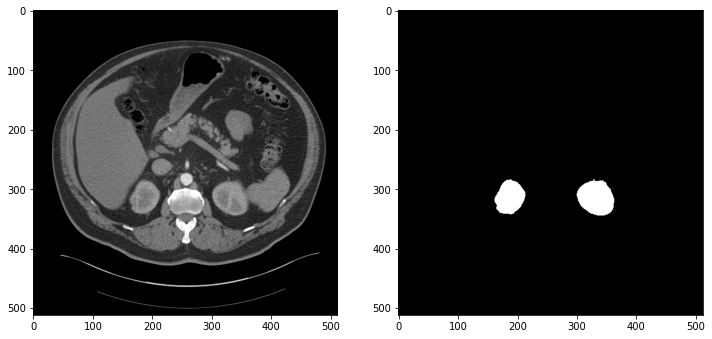

In [10]:
# Create data loader
data_loader = KitsDataset(BASEDIR, "val")
# Find a slice that contains kidney annotations
# item[0] is the annotation: (id, annotation_data)
annotation, image_data, _ = next(
    item for item in data_loader if np.count_nonzero(item[0][1]) > 5000
)

# The data loader returns images as floating point data with (C,H,W) layout. Convert to 8-bit
# integer data and transpose to (H,C,W) for visualization
image = image_data.astype(np.uint8).transpose(1, 2, 0)

# The data loader returns annotations as (index, mask) and mask in shape (1,H,W)
# grab only the mask, and remove the channel dimension for visualization
mask = annotation[1].squeeze()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap="gray")
ax[1].imshow(mask, cmap="gray");

#### Quantization Config

POT methods expect configuration dictionaries as arguments, which are defined in the cell below. The variable `ir_path` is defined in the [Settings](#Settings) cell at the top of the notebook. The other variables are defined in the cell above.

See [Post-Training Optimization Best Practices](https://docs.openvino.ai/2021.4/pot_docs_BestPractices.html) for more information on the settings.

In [11]:
# Model config specifies the model name and paths to model .xml and .bin file
model_config = Dict(
    {
        "model_name": f"quantized_{ir_path.stem}",
        "model": ir_path,
        "weights": ir_path.with_suffix(".bin"),
    }
)

# Engine config
engine_config = Dict({"device": "CPU"})

algorithms = [
    {
        "name": "DefaultQuantization",
        "stat_subset_size": 900,
        "params": {
            "target_device": "ANY",
            "preset": "performance",  # choose between "mixed" and "performance"
        },
    }
]

print(f"model_config: {model_config}")

model_config: {'model_name': 'quantized_pretrained_unet_kits19', 'model': PosixPath('model/pretrained_unet_kits19.xml'), 'weights': PosixPath('model/pretrained_unet_kits19.bin')}


### Run Quantization Pipeline

The POT pipeline needs a loaded model, an`IEEngine` instance, a POT implementation of Inference Engine, and finally a POT `Pipeline` instance. The POT classes and functions expect a config argument. These configs are created in the Config section in the cell above. The F1 metric and SegmentationDataLoader are defined earlier in this notebook.

Running the POT quantization pipeline takes just two lines of code. We create the pipeline with the `create_pipeline` function, and then run that pipeline with `pipeline.run()`. To reuse the quantized model later, we compress the model weights and save the compressed model to disk.

In [12]:
# Step 1: create data loader
data_loader = KitsDataset(BASEDIR, "val")

# Step 2: load model
ir_model = load_model(model_config=model_config)

# Step 3: initialize the metric
metric = BinaryF1()

# Step 4: Initialize the engine for metric calculation and statistics collection.
engine = IEEngine(config=engine_config, data_loader=data_loader, metric=metric)

# Step 5: Create a pipeline of compression algorithms.
# quantization_algorithm is defined in the Settings
pipeline = create_pipeline(algorithms, engine)

# Step 6: Execute the pipeline to quantize the model
algorithm_name = pipeline.algo_seq[0].name
preset = pipeline._algo_seq[0].config["preset"]
with yaspin(
    text=f"Executing POT pipeline on {model_config['model']} with {algorithm_name}, {preset} preset"
) as sp:
    start_time = time.perf_counter()
    compressed_model = pipeline.run(ir_model)
    end_time = time.perf_counter()
    sp.text = f"Quantization finished in {end_time - start_time:.2f} seconds"
    sp.ok("✔")

# Step 7 (Optional): Compress model weights to quantized precision
#                    in order to reduce the size of the final .bin file.
compress_model_weights(compressed_model)

# Step 8: Save the compressed model to the desired path.
# Set save_path to the directory where the model should be saved
compressed_model_paths = save_model(
    model=compressed_model,
    save_path="optimized_model",
    model_name=f"{ir_model.name}_{preset}_{algorithm_name}",
)

compressed_model_path = compressed_model_paths[0]["model"]
print("The quantized model is stored at", compressed_model_path)

Created val dataset with 4264 items. Base directory for data: /home/helena/code/kidney_segmentation/kits19_frames
✔ Quantization finished in 2184.92 secondsunet_kits19.xml with DefaultQuantization, performance preset25h
The quantized model is stored at optimized_model/quantized_pretrained_unet_kits19_performance_DefaultQuantization.xml


## Compare Metrics of FP16 and INT8 Model

In [ ]:
# Compute the F1 score on the original and quantized model
ir_model = load_model(model_config=model_config)
evaluation_pipeline = create_pipeline(algo_config=algorithms, engine=engine)

with yaspin(text="Evaluating original IR model") as sp:
    original_metric = evaluation_pipeline.evaluate(ir_model)

with yaspin(text="Evaluating quantized IR model") as sp:
    quantized_metric = pipeline.evaluate(compressed_model)

if original_metric:
    for key, value in original_metric.items():
        print(f"The {key} score of the original FP16 model is {value:.3f}")

if quantized_metric:
    for key, value in quantized_metric.items():
        print(f"The {key} score of the quantized INT8 model is {value:.3f}")

⠙ Evaluating quantized IR model[?25h

## Compare Performance of the Original and Quantized Models

To measure the inference performance of the FP16 and INT8 models, we use [Benchmark Tool](https://docs.openvinotoolkit.org/latest/openvino_inference_engine_tools_benchmark_tool_README.html), OpenVINO's inference performance measurement tool. Benchmark tool is a command line application that can be run in the notebook with `! benchmark_app` or `%sx benchmark_app`.

In this tutorial, we use a wrapper function from [Notebook Utils](https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/utils/notebook_utils.ipynb). It prints the `benchmark_app` command with the chosen parameters.

> NOTE: For the most accurate performance estimation, we recommended running `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app --help` to see all command line options.

In [ ]:
# Show the parameters and docstring for `benchmark_model`
benchmark_model?

In [14]:
# By default, benchmark on MULTI:CPU,GPU if a GPU is available, otherwise on CPU.
ie = IECore()
device = "MULTI:CPU,GPU" if "GPU" in ie.available_devices else "CPU"
# Uncomment one of the options below to benchmark on other devices
# device = "GPU"
# device = "CPU"
# device = "AUTO"

In [15]:
# Benchmark FP16 model
benchmark_model(model_path=ir_path, device=device, seconds=15)

**Benchmark pretrained_unet_kits19.xml with MULTI:CPU,GPU for 15 seconds with async inference**

Benchmark command: `benchmark_app -m model/pretrained_unet_kits19.xml -d MULTI:CPU,GPU -t 15 -api async -b 1 -cdir model_cache`

Count:      336 iterations
Duration:   15504.17 ms
Throughput: 21.67 FPS

CPU device: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz
GPU device: Intel(R) Gen12LP HD Graphics (iGPU)


In [16]:
# Benchmark INT8 model
benchmark_model(model_path=compressed_model_path, device=device, seconds=15)

**Benchmark quantized_pretrained_unet_kits19_performance_DefaultQuantization.xml with MULTI:CPU,GPU for 15 seconds with async inference**

Benchmark command: `benchmark_app -m optimized_model/quantized_pretrained_unet_kits19_performance_DefaultQuantization.xml -d MULTI:CPU,GPU -t 15 -api async -b 1 -cdir model_cache`

Count:      936 iterations
Duration:   17086.76 ms
Throughput: 54.78 FPS

CPU device: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz
GPU device: Intel(R) Gen12LP HD Graphics (iGPU)


## Visually Compare Inference Results

Visualize the results of the model on four slices of the validation set. Compare the results of the FP16 IR model with the results of the quantized INT8 model and the reference segmentation annotation.

Medical imaging datasets tend to be very imbalanced: most of the slices in a CT scan do not contain kidney data. The segmentation model should be good at finding kidneys where they exist (in medical terms: have good sensitivity) but also not find spurious kidneys that do not exist (have good specificity). In the next cell, we show four slices: two slices that have no kidney data, and two slices that contain kidney data. For this example, a slice has kidney data if at least 50 pixels in the slices are annotated as kidney.

Run this cell again to show results on a different subset. The random seed is displayed to allow reproducing specific runs of this cell.

> Note: the images are shown after optional augmenting and resizing. In the Kits19 dataset all but one of the cases has input shape `(512, 512)`. 

In [17]:
num_images = 4
colormap = "gray"

ie = IECore()
net_ir = ie.read_network(ir_path)
net_pot = ie.read_network(compressed_model_path)

exec_net_ir = ie.load_network(network=net_ir, device_name="CPU")
exec_net_pot = ie.load_network(network=net_pot, device_name="CPU")
input_layer = next(iter(net_ir.input_info))
output_layer_ir = next(iter(net_ir.outputs))
output_layer_pot = next(iter(net_pot.outputs))

Visualizing results with seed 1644684551


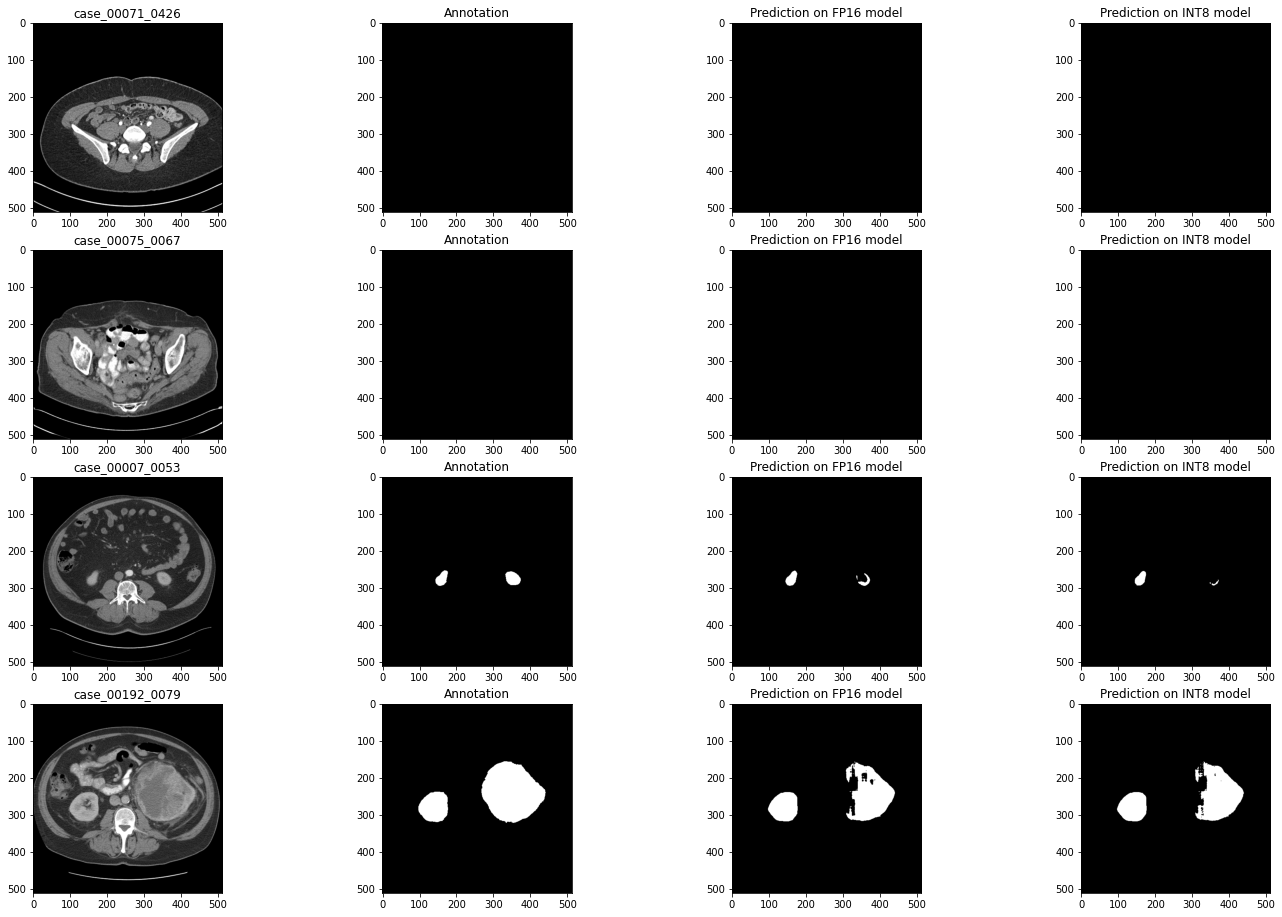

In [18]:
# Create a dataset, and make a subset of the dataset for visualization
# The dataset items are (annotation, image) where annotation is (index, mask)
background_slices = (item for item in data_loader if np.count_nonzero(item[0][1]) == 0)
kidney_slices = (item for item in data_loader if np.count_nonzero(item[0][1]) > 50)
# Set seed to current time. To reproduce specific results, copy the printed seed
# and manually set `seed` to that value.
seed = int(time.time())
random.seed(seed)
print(f"Visualizing results with seed {seed}")
data_subset = random.sample(list(background_slices), 2) + random.sample(
    list(kidney_slices), 2
)

fig, ax = plt.subplots(nrows=num_images, ncols=4, figsize=(24, num_images * 4))
for i, (annotation, image, meta) in enumerate(data_subset):
    mask = annotation[1]
    res_ir = exec_net_ir.infer(inputs={input_layer: image})
    res_pot = exec_net_pot.infer(inputs={input_layer: image})
    target_mask = mask.astype(np.uint8)

    result_mask_ir = sigmoid(res_ir[output_layer_ir]).round().astype(np.uint8)[0, 0, ::]
    result_mask_pot = (
        sigmoid(res_pot[output_layer_pot]).round().astype(np.uint8)[0, 0, ::]
    )

    ax[i, 0].imshow(image[0, ::], cmap=colormap)
    ax[i, 1].imshow(target_mask, cmap=colormap)
    ax[i, 2].imshow(result_mask_ir, cmap=colormap)
    ax[i, 3].imshow(result_mask_pot, cmap=colormap)
    ax[i, 0].set_title(f"{meta['slice']}")
    ax[i, 1].set_title("Annotation")
    ax[i, 2].set_title("Prediction on FP16 model")
    ax[i, 3].set_title("Prediction on INT8 model")

## Show Live Inference

To show live inference on the model in the notebook, we use the asynchronous processing feature of OpenVINO Inference Engine.

If you use a GPU device, with `device="GPU"` or `device="MULTI:CPU,GPU"` to do inference on an integrated graphics card, model loading will be slow the first time you run this code. The model will be cached, so after the first time model loading will be fast. See the [OpenVINO API tutorial](../002-openvino-api/002-openvino-api.ipynb) for more information on Inference Engine, including Model Caching.

We use the `show_live_inference` function from [Notebook Utils](../utils/notebook_utils.ipynb) to show live inference. This function uses [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/)'s AsyncPipeline and Model API to perform asynchronous inference. After inference on the specified CT scan has completed, the total time and throughput (fps), including preprocessing and displaying, will be printed.

### Load Model and List of Image Files

We load the segmentation model to Inference Engine with `SegmentationModel`, based on the [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) Model API. This model implementation includes pre and post processing for the model. For `SegmentationModel` this includes the code to create an overlay of the segmentation mask on the original image/frame. Uncomment the next cell to see the implementation.



In [ ]:
# SegmentationModel??

In [ ]:
# CASE = 117

ie = IECore()
segmentation_model = SegmentationModel(
    ie=ie, model_path=Path(compressed_model_path), sigmoid=True
)
case_path = BASEDIR / f"case_{CASE:05d}"
image_paths = sorted(case_path.glob("imaging_frames/*jpg"))
print(f"{case_path.name}, {len(image_paths)} images")

### Show Inference

In the next cell, we run the `show_live_inference` function, which loads the `segmentation_model` to the specified `device` (using caching for faster model loading on GPU devices), loads the images, performs inference, and displays the results on the frames loaded in `images` in real-time.

In [ ]:
# Possible options for device include "CPU", "GPU", "AUTO", "MULTI"
device = "MULTI:CPU,GPU" if "GPU" in ie.available_devices else "CPU"
show_live_inference(
    ie=ie, image_paths=image_paths, model=segmentation_model, device=device
)

## References

**OpenVINO**

- [Post Training Optimization Tool (POT)](https://docs.openvino.ai/2021.4/pot_README.html)
- [OpenVINO MULTI device plugin](https://docs.openvino.ai/latest/openvino_docs_IE_DG_supported_plugins_MULTI.html)
- [OpenVINO API Tutorial](../002-openvino-api/002-openvino-api.ipynb)
- [OpenVINO PyPI (pip install openvino-dev)](https://pypi.org/project/openvino-dev/)

**Kits19 Data**
  - [Kits19 Challenge Homepage](https://kits19.grand-challenge.org/)
  - [Kits19 Github Repository](https://github.com/neheller/kits19)
  - [The KiTS19 Challenge Data: 300 Kidney Tumor Cases with Clinical Context, CT Semantic Segmentations, and Surgical Outcomes](https://arxiv.org/abs/1904.00445)
  - [The state of the art in kidney and kidney tumor segmentation in contrast-enhanced CT imaging: Results of the KiTS19 challenge](https://www.sciencedirect.com/science/article/pii/S1361841520301857)
